<a href="https://colab.research.google.com/github/dominiquebuford/CV_project3/blob/dombuford/run_cGAN_withimageinput.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# set up access to Kaggle API
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json
kaggle.json


In [2]:
import pandas as pd
!pip install -q --upgrade torch_snippets
from torch_snippets import *
device = "cuda" if torch.cuda.is_available() else "cpu"
from torchvision.utils import make_grid
from torch_snippets import *
from PIL import Image
import torchvision
from torchvision import transforms
import torchvision.utils as vutils

In [3]:
!kaggle datasets download -d yuulind/imdb-clean


100% 6.82G/6.83G [01:03<00:00, 88.5MB/s]
100% 6.83G/6.83G [01:03<00:00, 116MB/s] 


In [4]:
!unzip imdb-clean.zip

Streaming output truncated to the last 5000 lines.
  inflating: imdb-clean-1024/imdb-clean-1024/98/nm0000198_rm869117184_1958-3-21_2013.jpg  
  inflating: imdb-clean-1024/imdb-clean-1024/98/nm0000198_rm877632256_1958-3-21_2002.jpg  
  inflating: imdb-clean-1024/imdb-clean-1024/98/nm0000198_rm893175808_1958-3-21_2014.jpg  
  inflating: imdb-clean-1024/imdb-clean-1024/98/nm0000198_rm894409472_1958-3-21_2002.jpg  
  inflating: imdb-clean-1024/imdb-clean-1024/98/nm0000198_rm911186688_1958-3-21_2002.jpg  
  inflating: imdb-clean-1024/imdb-clean-1024/98/nm0000198_rm911514112_1958-3-21_2005.jpg  
  inflating: imdb-clean-1024/imdb-clean-1024/98/nm0000198_rm921014016_1958-3-21_2010.jpg  
  inflating: imdb-clean-1024/imdb-clean-1024/98/nm0000198_rm928291328_1958-3-21_2005.jpg  
  inflating: imdb-clean-1024/imdb-clean-1024/98/nm0000198_rm994688768_1958-3-21_2007.jpg  
  inflating: imdb-clean-1024/imdb-clean-1024/98/nm0000298_rm1283956736_1946-5-9_1975.jpg  
  inflating: imdb-clean-1024/imdb-clean

In [5]:
df = pd.read_csv('imdb_train_new_1024.csv')

In [6]:
#df_check = df[np.abs(df['head_roll'])<4]
df_check = df[np.abs(df['head_yaw'])<1]
#df_check = df_check[np.abs(df_check['head_pitch'])<4]

df_check.reset_index(drop=True, inplace=True)


In [7]:
 #age range 1-95
age_categories = {
    'age_1_20': range(1, 21),
    'age_21_40': range(21, 41),
    'age_41_60': range(41, 61),
    'age_61_80': range(61, 81),
    'age_81_100': range(81, 101)
}

# Initialize an empty DataFrame to store one-hot encoded values
df_encoded = df_check.loc[:, ['filename', 'gender', 'x_min', 'y_min', 'x_max', 'y_max']].copy()

# One-hot encode the 'age' column based on custom age categories
for category, age_range in age_categories.items():
    df_encoded[category] = df_check['age'].apply(lambda x: 1 if x in age_range else 0)


#calculate height,width for crop
df_encoded['height'] = df_encoded['y_max'] - df_encoded['y_min']
df_encoded['width'] = df_encoded['x_max'] - df_encoded['x_min']


In [8]:
import os

In [23]:
!mkdir cropped_faces

paths = df_encoded['filename'].tolist()
x_mins = df_encoded['x_min'].tolist()
y_mins = df_encoded['y_min'].tolist()
heights = df_encoded['height'].tolist()
widths = df_encoded['width'].tolist()

original_folder = 'imdb-clean-1024/imdb-clean-1024'
for i in range(len(paths)):
  y = int(y_mins[i])
  x = int(x_mins[i])
  h = int(heights[i])
  w = int(widths[i])
  fullName = os.path.join(original_folder, paths[i])
  img = read(fullName, 1)
  img2 = img[y:(y+h),x:(x+w),:]

  finalImageName ='cropped_faces/'
  if df_encoded.loc[i, 'age_21_40'] == 1:
    finalImageName += 'age_21_40_'
  elif df_encoded.loc[i, 'age_41_60'] ==1:
    finalImageName+='age_41_60_'
  elif df_encoded.loc[i, 'age_61_80'] ==1:
    finalImageName+='age_61_80_'
  elif df_encoded.loc[i, 'age_81_100'] ==1:
    finalImageName+='age_81_100_'
  else:
    finalImageName+='age_1_20_'


  cv2.imwrite(finalImageName+str(i)+'.jpg',cv2.cvtColor(img2, cv2.COLOR_RGB2BGR))



In [3]:
transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

In [26]:
class Faces(Dataset):
    def __init__(self, folder):
        super().__init__()
        self.folder = [os.path.join(folder, x) for x in os.listdir(folder)]
    def __len__(self):
        return len(self.folder)
    def __getitem__(self, ix):
      path = self.folder[ix]
      image =Image.open(path)
      image = transform(image)
      ages = ['age_1_20', 'age_21_40', 'age_41_60', 'age_61_80', 'age_81_100']
      age_label = np.argmax([age_category in str(path) for age_category in ages])

      return image,torch.tensor(age_label).long()


In [27]:
ds = Faces(folder= 'cropped_faces')
dataloader = DataLoader(ds, batch_size=50, shuffle=True, num_workers=8)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
class Discriminator(nn.Module):
    def __init__(self, emb_size = 32):
        super(Discriminator, self).__init__()
        self.emb_size = emb_size
        self.label_embeddings = nn.Embedding(5, self.emb_size)
        self.model = nn.Sequential(
            nn.Conv2d(3,64,4,2,1,bias=False),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64,64*2,4,2,1,bias=False),
            nn.BatchNorm2d(64*2),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*2,64*4,4,2,1,bias=False),
            nn.BatchNorm2d(64*4),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*4,64*8,4,2,1,bias=False),
            nn.BatchNorm2d(64*8),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*8,64,4,2,1,bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Flatten()
        )
        self.model2 = nn.Sequential(
            nn.Linear(288,100),   #image size is 64 x 2 x 2 + 32(the label embedding) = 288
            nn.LeakyReLU(0.2,inplace=True),
            nn.Linear(100,1),
            nn.Sigmoid()
        )
        self.apply(weights_init)
    def forward(self, input, labels):
        x = self.model(input)
        y = self.label_embeddings(labels)
        input = torch.cat([x, y], 1)
        final_output = self.model2(input)
        return final_output

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        conv_block = [nn.ReflectionPad2d(1),
                      nn.Conv2d(in_features, in_features, 3),
                      nn.BatchNorm2d(in_features),
                      nn.ReLU(),
                      nn.ReflectionPad2d(1),
                      nn.Conv2d(in_features, in_features, 3),
                      nn.BatchNorm2d(in_features)]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

In [9]:
class Generator(nn.Module):
    def __init__(self, emb_size = 32):
        super(Generator,self).__init__()
        self.emb_size = emb_size
        self.label_embeddings = nn.Embedding(5, self.emb_size)
        self.model = nn.Sequential(
              nn.ConvTranspose2d(64*5 + 100 +32, 64*16, 4, 2, 1, bias=False),  # Upsample to 2x2
              nn.BatchNorm2d(64*16),
              nn.ReLU(True),
              nn.ConvTranspose2d(64*16, 64*8, 4, 2, 1, bias=False),  # Upsample to 4x4
              nn.BatchNorm2d(64*8),
              nn.ReLU(True),
              nn.ConvTranspose2d(64*8, 64*4, 4, 2, 1, bias=False),  # Upsample to 8x8
              nn.BatchNorm2d(64*4),
              nn.ReLU(True),
              nn.ConvTranspose2d(64*4, 64*2,4,2, 1 , bias = False),
              nn.BatchNorm2d(64*2),
              nn.ReLU(True),
              nn.ConvTranspose2d(64*2, 64,4,2, 1 , bias = False),
              nn.BatchNorm2d(64),
              nn.ReLU(True),
              nn.ConvTranspose2d(64, 3,4,2, 1 , bias = False),
              nn.Tanh()
          )
        self.downsampleInputImage = nn.Sequential(
            nn.Conv2d(3,32,4,2,1,bias=False),
            nn.LeakyReLU(0.2,inplace=True),
            nn.BatchNorm2d(32),
            nn.Conv2d(32,64,4,2,1,bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64,64*2,4,2,1,bias=False),
            nn.BatchNorm2d(64*2),
            nn.LeakyReLU(0.2,inplace=True),
            ResidualBlock(64*2),
            ResidualBlock(64*2),
            ResidualBlock(64*2),
            ResidualBlock(64*2),
            nn.Conv2d(64*2,64*3,4,2,1,bias=False),
            nn.BatchNorm2d(64*3),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*3,64*4,4,2,1,bias=False),
            nn.BatchNorm2d(64*4),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*4,64*5,4,2,1,bias=False),
            nn.BatchNorm2d(64*5),
            nn.LeakyReLU(0.2,inplace=True),
        )
        self.residual = ResidualBlock(64*2)
        self.apply(weights_init)
    def forward(self,images, z, labels):
        x = self.downsampleInputImage(images)
        label_embeddings = self.label_embeddings(labels).view(len(labels), self.emb_size, 1, 1)
        input = torch.cat([z, x, label_embeddings], 1)
        return self.model(input)

In [10]:
def noise(size):
    n = torch.randn(size, 100, 1, 1, device=device)
    return n.to(device)

In [11]:
def discriminator_train_step(real_data, real_labels,fake_data, fake_labels):
    d_optimizer.zero_grad()
    prediction_real = discriminator(real_data, real_labels)
    error_real = loss(prediction_real, torch.ones(len(real_data), 1).to(device))
    error_real.backward()
    prediction_fake = discriminator(fake_data, fake_labels)
    error_fake = loss(prediction_fake, torch.zeros(len(fake_data), 1).to(device))
    error_fake.backward()
    d_optimizer.step()
    return error_real + error_fake

In [12]:
vgg_model = torchvision.models.vgg16(pretrained=True).features.to(device).eval()

# Define the layers you want to use for perceptual loss
perceptual_loss_layers = ['conv3_3', 'conv4_3']

def compute_perceptual_loss(fake_images, real_images):
    # Compute feature representations of fake and real images
    fake_features = vgg_model(fake_images)
    real_features = vgg_model(real_images)

    # Compute perceptual loss as the mean squared error between feature representations
    perceptual_loss = 0
    for fake_feat, real_feat in zip(fake_features, real_features):
        perceptual_loss += F.mse_loss(fake_feat, real_feat)

    return perceptual_loss

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [37]:
def generator_train_step(fake_data,fake_labels, real_data):
    g_optimizer.zero_grad()
    #perceptual_loss = compute_perceptual_loss(fake_data, real_data)
    prediction = discriminator(fake_data, fake_labels)
    error = loss(prediction, torch.ones(len(fake_data), 1).to(device))
    #total_loss = error + perceptual_loss
    error.backward()
    g_optimizer.step()
    return error

In [40]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)
loss = nn.BCELoss()
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=0.0001)
g_optimizer = optim.Adam(generator.parameters(), lr=0.01, betas=(0.5, 0.999), weight_decay=0.0001)
fixed_noise = torch.randn(50, 100, 1, 1, device=device)
fixed_fake_labels = torch.LongTensor([0]*(len(fixed_noise)//5) + [1]*(len(fixed_noise)//5) + [2]*(len(fixed_noise)//5) + [3]*(len(fixed_noise)//5) + [4]*(len(fixed_noise)//5)).to(device)
loss = nn.BCELoss()
n_epochs = 100
img_list = []

for batch_idx, batch_data in enumerate(dataloader):
    if batch_idx == 0:
        first_batch = batch_data
        break
test_images, labels = first_batch

EPOCH: 1.000  g_loss: 5.119  d_loss: 0.055  (16.59s - 1642.33s remaining)


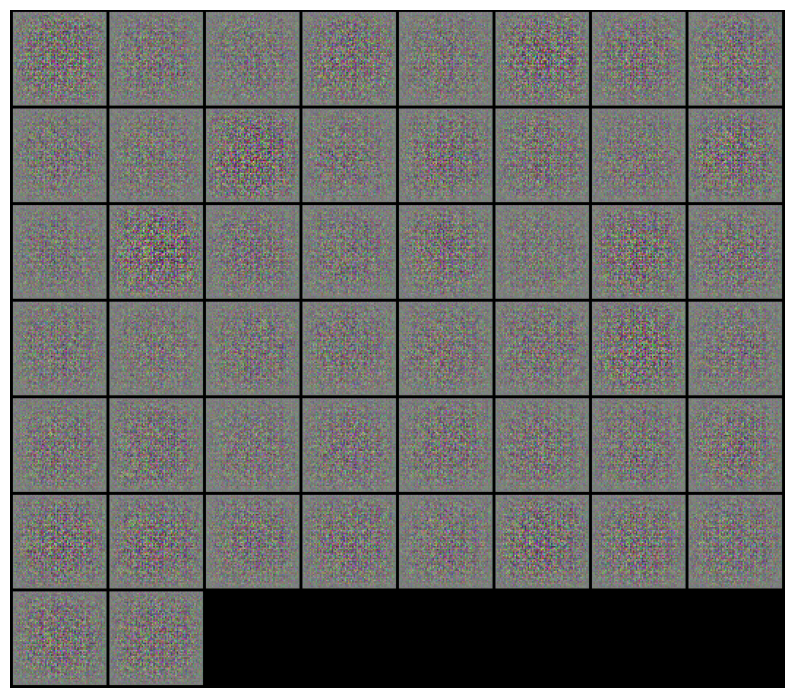

EPOCH: 2.000  g_loss: 7.523  d_loss: 0.001  (33.80s - 1656.27s remaining)


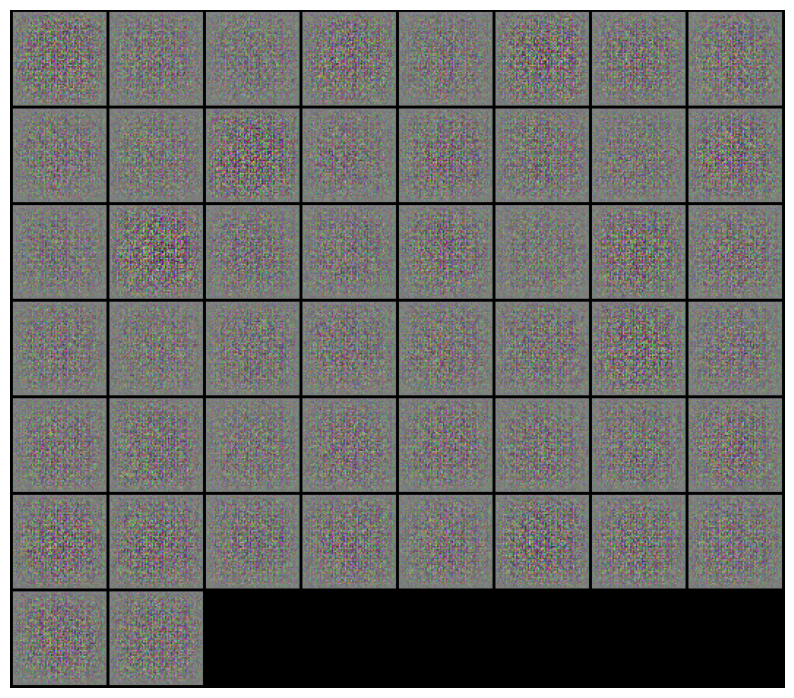

EPOCH: 3.000  g_loss: 8.482  d_loss: 0.000  (52.17s - 1686.83s remaining)


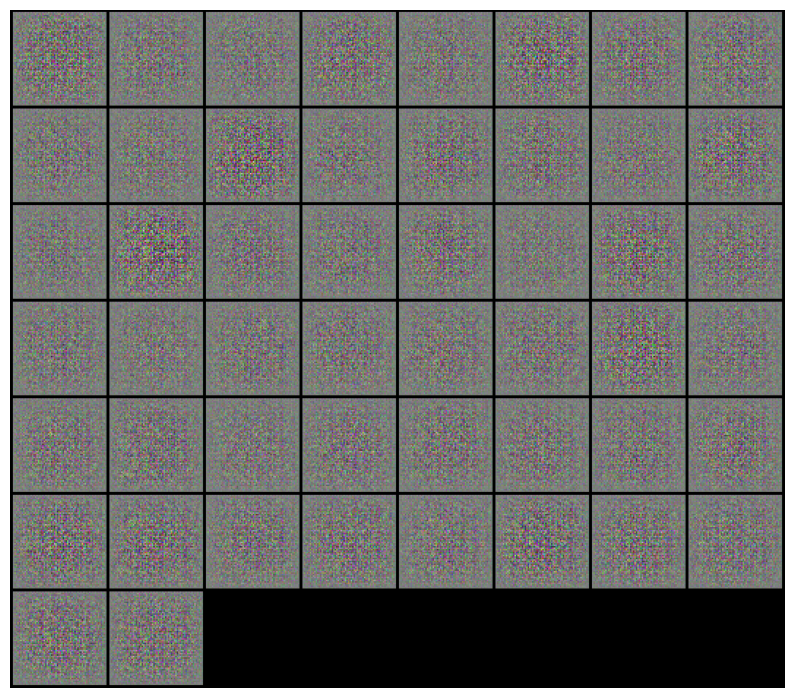

KeyboardInterrupt: 

In [41]:
log = Report(n_epochs)
for epoch in range(n_epochs):
    N = len(dataloader)
    for bx, (images, labels) in enumerate(dataloader):
        real_data, real_labels= images.to(device), labels.to(device)
        fake_labels = torch.LongTensor(np.random.randint(0, 5, len(real_data))).to(device)
        fake_data = generator(real_data, noise(len(real_data)),fake_labels).to(device)
        fake_data = fake_data.detach()
        d_loss = discriminator_train_step(real_data, real_labels, fake_data, fake_labels)

        fake_labels = torch.LongTensor(np.random.randint(0, 5, len(real_data))).to(device)
        fake_image_old = generator(real_data, noise(len(real_data)), fake_labels).to(device)
        g_loss = generator_train_step(fake_data, fake_labels, real_data)
        pos = epoch + (1+bx)/N
        log.record(pos, d_loss=d_loss.detach(), g_loss=g_loss.detach(), end='\r')
    log.report_avgs(epoch+1)
    with torch.no_grad():
        fake = generator(test_images.to(device), fixed_noise, fixed_fake_labels).detach().cpu()
        imgs = vutils.make_grid(fake, padding=2, normalize=True).permute(1,2,0)
        img_list.append(imgs)
        show(imgs, sz=10)




In [ ]:
torch.save(generator.state_dict(), 'generator_weights.pth')
generator.eval()
with torch.no_grad():
  image = Image.open('cropped_faces_young/1013.jpg')
  image = transform(image)


  image = image.unsqueeze(0)
  print(image.shape)
  img_list = []
  generator= generator.to(device)
  fake_data = generator(image.to(device), noise(len(image)).to(device))
  fake_data = fake_data.detach()


  imgs = vutils.make_grid(fake_data, padding=2, normalize=True).permute(1,2,0)
  img_list.append(imgs)
  show(imgs, sz=2)
